# Convolutional Neural Networks in PyTorch

While convolutional neural networks (CNNs) see a wide variety of uses, they were originally designed for images, and CNNs are still most commonly used for vision-related tasks. For part 2 of mandatory assignment 1, we'll be focusing on CNNs for images. Before we dive into convolutions and neural networks, it's worth prefacing with how images are represented by a computer, as this understanding will inform some of our design choices.

Below is an example of a digitized MNIST handwritten digit.
Specifically, we represent it as an $H \times W$ table, with the value of each element storing the intensity of the corresponding pixel.

<img src="../media/mnist_digital.png" alt="mnist_digital" style="width: 600px;"/>

With a 2D representation as above, we for the most part can only efficiently represent grayscale images.<br>
*But what if we want to think of color as a feature*? <br> <br>
There are many schemes for storing color, but one of the most common ones is the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model).
In such a system, we store 3 tables of pixel intensities (each called a *channel*), one each for the colors red, green, and blue (hence RGB), resulting in an $H \times W \times 3$ tensor.
Pixel values for a particular channel indicate how much of the corresponding color the image has at a particular location.

Let's load an image and see this:

In [24]:
import imageio.v3 as imgio
import matplotlib.pyplot as plt
import numpy as np

# Display matplotlib plots inline in the notebook
%matplotlib inline

Shape of the image tensor: (620, 1175, 3)


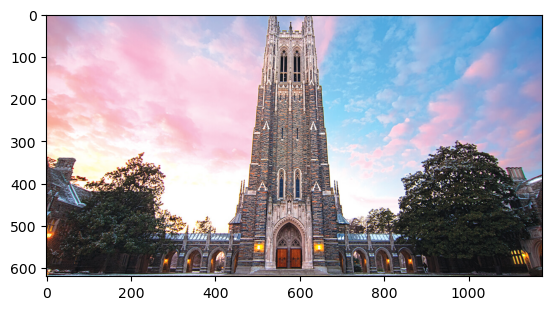

In [25]:
# Read image
im = imgio.imread("./media/rgb_example.jpg")
print(f"Shape of the image tensor: {im.shape}")

plt.imshow(im)

We can see that the image we loaded has height and width of $620 \times 1175$, with 3 channels corresponding to RGB.

We can easily slice out and view individual color channels:

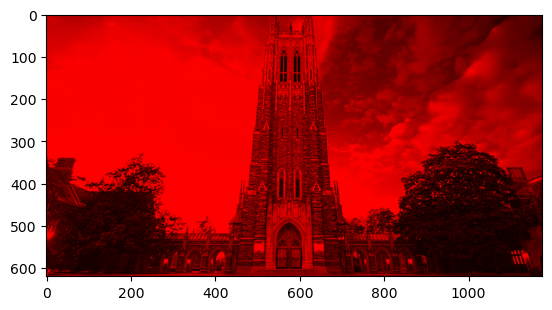

In [26]:
# Visualizing the red channel in red color
im_red_colored = np.zeros_like(im)  # Create a blank image of the same shape as the original
im_red_colored[:,:,0] = im[:,:,0]   # Set the red channel
# Display the red channel image
plt.imshow(im_red_colored)

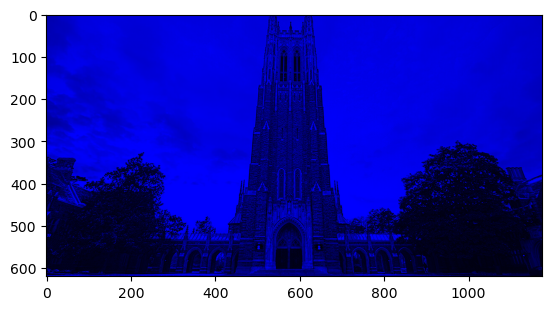

In [6]:
# Visualizing the blue channel in blue color
im_blue_color = np.zeros_like(im)  # Create a blank image of the same shape as the original
im_blue_color[:,:,2] = im[:,:,2]   # Set the blue channel
# Display the blue channel image
plt.imshow(im_blue_color)

While we have so far considered only 3 channel RGB images, there are many settings in which we may consider a different number of channels.
For example, [hyperspectral imaging](https://en.wikipedia.org/wiki/Hyperspectral_imaging) uses a wide range of the electromagnetic spectrum to characterize a scene.
Such modalities may have hundreds of channels or more.
Additionally, we'll soon see that certain intermediate representations in a CNN can be considered images with many channels.
However, we'll focus much of today's discussion to 1 channel grayscale and 3 channel RGB images as our inputs, as is most commonly the case in computer vision.

***

### Convolutions
Convolutional neural networks (CNNs) are a class of neural networks that have convolutional layers. CNNs are particularly effective for data that have spatial structures and correlations (e.g. images). We'll focus on CNNs applied to images in this tutorial.


Recall that a multilayer perceptron (MLP) is entirely composed of fully connected layers, which are each a matrix multiply operation (and addition of a bias) followed by a non-linearity (e.g. sigmoid, ReLU). 
A convolutional layer is similar, except the matrix multiply operation is replaced with a convolution operation (in practice a cross-correlation). 
Note that a CNN need not be entirely composed of convolutional layers; in fact, many popular CNN architectures end in fully connected layers.

As before, since we're building neural networks, let's start by loading PyTorch. We'll find NumPy useful as well, so we'll also import that here.

In [28]:
import numpy as np
import torch
import torch.nn.functional as F

#### Review: Fully connected layer
In a fully connected layer, the input $x \in \mathbb R^{M \times C_{in}}$ is a vector (or, rather a batch of vectors), where $M$ is the minibatch size and $C_{in}$ is the dimensionality of the input. 
We first matrix multiply the input $x$ by a weight matrix $W$.
This weight matrix has dimensions $W \in \mathbb R^{C_{in} \times C_{out}}$, where $C_{out}$ is the number of output units.
We then add a bias for each output, which we do by adding $b \in \mathbb{R}^{C_{out}}$.
The output $y \in \mathbb{R}^{M \times C_{out}}$ of the fully connected layer then:

```math
\begin{align*}
y = \text{ReLU}(x W + b)
\end{align*}
```

Remember, the values of $W$ and $b$ are variables that we are trying to learn for our model. 
Below we have a visualization of what the matrix operation looks like (bias term and activation function omitted).

<img src="../media/mnist_matmul.png" width="500"/>

In [9]:
# Create a random flat input vector
# Simulates input from a flattened 28x28 image (e.g., MNIST images) for a batch of 100 examples
x_fc = torch.randn(100, 784)

# Create weight matrix variable
# Randomly initialize weights for a fully connected layer with 784 input features and 10 output features
# The weights are scaled by 1/sqrt(784) for better initialization stability
W = torch.randn(784, 10) / np.sqrt(784)
W.requires_grad_()  # Enable gradient computation for optimization

# Create bias variable
# Initialize bias for the 10 output features to zero
# Bias is also trainable, so gradients are required
b = torch.zeros(10, requires_grad=True)

# Apply fully connected layer
# Compute the pre-activation output (y_preact) as a linear transformation of the input
# y_preact = x_fc @ W + b
y_preact = torch.matmul(x_fc, W) + b

# Apply ReLU activation function
# ReLU introduces non-linearity, setting negative values in y_preact to zero
y = F.relu(y_preact)

# Print input/output shape
# Input: 100 samples of 784 features (flattened 28x28 images)
# Output: 100 samples of 10 features (e.g., 10 classes for classification)
print(f"Input shape: {x_fc.shape}")
print(f"Output shape: {y.shape}")


Input shape: torch.Size([100, 784])
Output shape: torch.Size([100, 10])


#### Convolutional layer

In a convolutional layer, we convolve the input $x$ with a convolutional kernel (aka filter), which we also call $W$, producing output $y$:

\begin{align*}
y = \text{ReLU}(W*x + b)
\end{align*}

In the context of CNNs, the output $y$ is often referred to as feature maps. As with a fully connected layer, the goal is to learn $W$ and $b$ for our model.

Unlike the input of a fully connected layer, which is $x \in \mathbb R^{M\times C_{in}}$, the dimensionality of an image input is 4D: $x \in \mathbb R^{M \times C_{in} \times H_{in} \times W_{in}}$, where $M$ is still the batch size, $C_{in}$ is the number of channels of the input (e.g. 3 for RGB), and $H_{in}$ and $W_{in}$ are the height and width of the image.

The weight parameter $W$ is also different in a convolutional layer.
Unlike the 2-D weight matrix for fully connected layers, the kernel is 4-D with dimensions $W \in \mathbb R^{C_{out} \times C_{in} \times H_K \times W_K }$, where $H_K$ and $W_K$ are the kernel height and weight, respectively.
A common choice for $H_K$ and $W_K$ is $H_K = W_K = 3$ or $5$, but this tends to vary depending on the architecture.
Convolving the input with the kernel and adding a bias then gives an output $y \in \mathbb R^{M \times C_{out} \times H_{out} \times W_{out}}$.
If we use "same" padding and a stride of $1$ in our convolution (more on this later), our output will have the same spatial dimensions as the input: $H_{out}=H_{in}$ and $W_{out}=W_{in}$.

If you're having trouble visualizing this operation in 4D, it's easier to think about for a single member of the minibatch, one convolutional kernel at a time. 
Consider a stack of $C_{out}$ number of kernels, each of which are 3D ($C_{in} \times H_K \times W_K $). 
This 3D volume is then slid across the input (which is also 3D: $C_{in} \times H_{in} \times W_{in}$) in the two spatial dimensions (along $H_{in}$ and $W_{in}$). 
The outputs of the multiplication of the kernel and the input at every location creates a single feature map that is $H_{out} \times W_{out}$. 
Stacking the feature maps generated by each kernel gives the 3D output $C_{out} \times H_{out} \times W_{out} $.
Repeat the process for all $M$ inputs in the minibatch, and we get a 4D output $M  \times C_{out} \times H_{out} \times W_{out}$.

<img src="../media/conv_filters.png" alt="Convolutional filters" style="width: 600px;"/>

A few more things to note:
- Notice the ordering of the dimensions of the input (batch, channels in, height, width).
This is commonly referred to as $NCHW$ ordering.
Many other languages and libraries (e.g. MATLAB, TensorFlow, the image example at the beginning of this notebook) instead default to the slightly different $NHWC$ ordering.
PyTorch defaults to $NCHW$, as it more efficient computationally, especially with CUDA. 
- An additional argument for the convolution is the *stride*, which controls the how far we slide the convolutional filter as we move it along the input image. 
The convolutional operator, from its signal processing roots, by default considers a stride length of 1 in all dimensions, but in some situations we would like to consider strides more than 1 (or even less than 1). 
More on this later.
- In the context of signal processing, convolutions usually result in outputs that are larger than the input size, which results from when the kernel "hangs off the edge" of the input on both sides. 
This might not always be desirable.
We can control this by controlling the padding of the input.
Typically, we use pad the input to ensure the output has the same spatial dimensions as the input (assuming stride of 1); this makes it easier for us to keep track of what the size of our model is.

Let's implement this convolution operator in code.
There is a convolution implementation in `torch.nn.functional`, which we use here.

In [10]:
# Create a random image input tensor
x_cnn = torch.randn(100, 1, 28, 28)

# Create convolutional kernel variable
W1 = torch.randn(16, 1, 3, 3)/np.sqrt(1*3*3)
W1.requires_grad_()

# Create bias variable
b1 = torch.zeros(16, requires_grad=True)

# Apply convolutional layer
conv1_preact = F.conv2d(x_cnn, W1, bias=b1, stride=1, padding=1)
conv1 = F.relu(conv1_preact)

# Print input/output shape
print("Input shape: {}".format(x_cnn.shape))
print("Convolution output shape: {}".format(conv1.shape))

Input shape: torch.Size([100, 1, 28, 28])
Convolution output shape: torch.Size([100, 16, 28, 28])


Just like in a MLP, we can stack multiple of these convolutional layers. 
In the *Representing Images Digitally* section, we briefly mentioned considering images with channels more than 3.
Observe that the input to the second layer (i.e. the output of the first layer) can be viewed as an "image" with $C_{out}$ channels.
Instead of each channel representing a color content though, each channel effectively represents how much the original input image activated a particular convolutional kernel.
Given $C_{out}$ kernels that are each $C_{in} \times H_K \times W_K$, this results in $C_{out}$ channels for the output of the convolution.

Note that we need to change the dimensions of the convolutional kernel such that its input channels matches the number of output channels of the previous layer:

In [11]:
# 2nd layer variables
W2 = torch.randn(32, 16, 3, 3)/np.sqrt(16*3*3)
W2.requires_grad_()
b2 = torch.zeros(32, requires_grad=True)

# Apply 2nd convolutional layer
conv2 = F.relu(F.conv2d(conv1, W2, bias=b2, stride=1, padding=1))

# Print output shape
print("Second convolution output shape: {}".format(conv2.shape))

Second convolution output shape: torch.Size([100, 32, 28, 28])


In fact, we typically perform these convolution operations many times. 
Popular CNN architectures for image analysis today can be 100+ layers.

### Reshaping

You'll commonly finding yourself needing to reshape tensors while building CNNs.
The PyTorch function for doing so is `view()`. 
Anyone familiar with NumPy will find it very similar to `np.reshape()`.
Importantly, the new dimensions must be chosen so that it is possible to rearrange the input into the shape of the output (i.e. the total number of elements must be the same).
As with NumPy, you can optionally replace one of the dimensions with a `-1`, which tells `torch` to infer the missing dimension.

In [12]:
import torch

M = torch.zeros(4, 3)

M2 = M.view(1,1,12)
M3 = M.view(2,1,2,3)
M4 = M.view(-1,2,3)
M5 = M.view(-1)

print(M,M2,M3,M4,M5)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]) tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]) tensor([[[[0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.]]]]) tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


To get an idea of why reshaping is need in a CNN, let's look at a diagram of a simple CNN.

<img src="../media/CNN.png" alt="mnist_cnn_ex" style="width: 500px;"/>

First of all, the CNN expects a 4D input, with the dimensions corresponding to `[batch, channel, height, width]`.
Your data may not come in this format, so you may have to reshape it yourself.

In [13]:
# Reshape flat input image into a 4D batched image input
x_flat = torch.randn(100, 784)
x_reshaped = x_flat.view(-1, 1, 28, 28)

# Print input shape
print(x_reshaped.shape,x_flat.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100, 784])


CNN architectures also commonly contain fully connected layers or a softmax, as we're often interested in classification.
Both of these expect 2D inputs with dimensions `[batch, dim]`, so you have to "flatten" a CNN's 4D output to 2D.
For example, to flatten the convolutional feature maps we created earlier:

In [14]:
# Flatten convolutional feature maps into a vector
h_flat = conv2.view(-1, 28*28*32)

# Print output shape
print(h_flat.shape)

torch.Size([100, 25088])


### Pooling and striding

Almost all CNN architectures incorporate either pooling or striding. This is done for a number of reasons, including:
- Dimensionality reduction: pooling and striding operations reduces computational complexity by shrinking the number of values passed to the next layer.
For example, a 2x2 maxpool reduces the size of the feature maps by a factor of 4.
- Translational invariance: Oftentimes in computer vision, we'd prefer that shifting the input by a few pixels doesn't change the output. Pooling and striding reduces sensitivity to exact pixel locations.
- Increasing receptive field: by summarizing a window with a single value, subsequent convolutional kernels are seeing a wider swath of the original input image. For example, a max pool on some input followed by a 3x3 convolution results in a kernel "seeing" a 6x6 region instead of 3x3.

#### Pooling
The two most common forms of pooling are max pooling and average pooling. 
Both reduce values within a window to a single value, on a per-feature-map basis.
Max pooling takes the maximum value of the window as the output value; average pooling takes the mean.

<img src="../media/maxpool.png" alt="avg_vs_max" style="width: 600px;"/>

In [16]:
# Taking the output we've been working with so far, first print its current size
print(f"Shape of conv2 feature maps before pooling: {conv2.shape}")

# Max pool and then print new shape
max_pool2 = F.max_pool2d(conv2, kernel_size=2)
print(f"Shape of conv2 feature maps after max pooling: {max_pool2.shape}")

# Average pool and then print new shape
avg_pool2 = F.avg_pool2d(conv2, kernel_size=2)
print(f"Shape of conv2 feature maps after avg pooling: {avg_pool2.shape}")

Shape of conv2 feature maps before pooling: torch.Size([100, 32, 28, 28])
Shape of conv2 feature maps after max pooling: torch.Size([100, 32, 14, 14])
Shape of conv2 feature maps after avg pooling: torch.Size([100, 32, 14, 14])


We can confirm that the two types of pooling behave how we'd expect:

In [17]:
# Recreate values in pooling figure and make it 4D
feature_map_fig = torch.tensor(np.array([[1,1,2,4],
                                        [5,6,7,8],
                                        [3,2,1,0],
                                        [1,2,3,4]], dtype=np.float32))
fmap_fig = feature_map_fig.view(1,1,4,4)
print(f"Feature map shape pre-pooling: {fmap_fig.shape}")
print(fmap_fig)

# Maxpool
max_pool_fig = F.max_pool2d(fmap_fig, kernel_size=2)
print("\nMax pool")
print(f"Shape: {max_pool_fig.shape}")
print(f"{torch.squeeze(max_pool_fig)}\n{max_pool_fig}")
print(torch.squeeze(max_pool_fig).shape)

# Avgpool
avg_pool_fig = F.avg_pool2d(fmap_fig, kernel_size=2)
print("\nAvg pool")
print(f"Shape: {avg_pool_fig.shape}")
print(torch.squeeze(avg_pool_fig))

Feature map shape pre-pooling: torch.Size([1, 1, 4, 4])
tensor([[[[1., 1., 2., 4.],
          [5., 6., 7., 8.],
          [3., 2., 1., 0.],
          [1., 2., 3., 4.]]]])

Max pool
Shape: torch.Size([1, 1, 2, 2])
tensor([[6., 8.],
        [3., 4.]])
tensor([[[[6., 8.],
          [3., 4.]]]])
torch.Size([2, 2])

Avg pool
Shape: torch.Size([1, 1, 2, 2])
tensor([[3.2500, 5.2500],
        [2.0000, 2.0000]])


#### Striding
One might expect that pixels in an image have high correlation with neighboring pixels, so we can save computation by skipping positions while sliding the convolutional kernel. 
By default, a CNN slides across the input one pixel at a time, which we call a stride of 1.
By instead striding by 2, we skip calculating 75% of the values of the output feature map, which yields a feature map that's half the size in each spatial direction.
Note, while pooling is an operation done after the convolution, striding is part of the convolution operation itself.

In [18]:
# Since striding is part of the convolution operation, we'll start with the feature maps before the 2nd convolution
print(f"Shape of conv1 feature maps: {conv1.shape}")

# Apply 2nd convolutional layer, with striding of 2
conv2_strided = F.relu(F.conv2d(conv1, W2, bias=b2, stride=2, padding=1))

# Print output shape
print(f"Shape of conv2 feature maps with stride of 2: {conv2_strided.shape}")

Shape of conv1 feature maps: torch.Size([100, 16, 28, 28])
Shape of conv2 feature maps with stride of 2: torch.Size([100, 32, 14, 14])


### Normalization

Deep neural networks often face challenges during training, such as vanishing or exploding gradients, unstable learning, and slower convergence. Normalization techniques, like **Batch Normalization**, are commonly used to address these issues and improve both the training process and the model's generalization.

#### What is Normalization?
In the context of CNNs, normalization refers to scaling and shifting the intermediate feature maps produced by a layer to improve their behavior during training. The key idea is to ensure that the distribution of the activations remains stable and consistent as they flow through the network, which helps subsequent layers learn more effectively.

#### Benefits of Normalization
- **Accelerates training**: By reducing internal covariate shift (i.e., changes in the distribution of layer inputs during training), normalization allows the network to converge faster.
- **Improves stability**: Gradients are less likely to explode or vanish, making optimization smoother.
- **Acts as regularization**: Batch Normalization introduces slight noise to the training process, which can have a regularizing effect and reduce overfitting.
- **Allows higher learning rates**: With more stable gradients, you can use higher learning rates to speed up convergence.

#### Batch Normalization
Batch Normalization is one of the most widely used normalization techniques. It works as follows:
1. **Compute mean and variance**: For each feature map (channel), calculate the mean and variance of its activations across the current batch.
2. **Normalize**: Subtract the mean and divide by the standard deviation to scale the activations to have zero mean and unit variance.
3. **Scale and shift**: Introduce learnable parameters (γ and β) to adjust the normalized values, allowing the network to recover the original distribution if needed.

The Batch Normalization formula:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}, \quad y_i = \gamma \hat{x}_i + \beta
$$

where:
- $\hat{x}_i$: Input activation
- $\mu$: Mean of the batch
- $\sigma^2$: Variance of the batch
- $\epsilon$: A small constant to prevent division by zero
- $\gamma$, $\beta$: Learnable parameters for scaling and shifting


In CNNs, feature maps at deeper layers can have vastly different ranges of values due to the nonlinear transformations applied. Batch Normalization ensures that all feature maps contribute meaningfully to the learning process, regardless of their scale, and prevents instability caused by extreme values.

Let’s see how Batch Normalization can be applied to a simple convolutional layer:


In [22]:
# define a random tensor that represents a batch of 3 images of size 3x5x5
input_tensor = torch.randn(3, 3, 5, 5)
print(f"Shape of input tensor: {input_tensor.shape}")

# Define a convolutional layer
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

# Add Batch Normalization layer
batch_norm = torch.nn.BatchNorm2d(16)

# Forward pass through convolutional layer
x = conv_layer(input_tensor)
print(f"Shape after Convolutional Layer: {x.shape}")

# Forward pass through Batch Normalization layer
x_normalized = batch_norm(x)
print(f"Shape after Batch Normalization: {x_normalized.shape}")

Shape of input tensor: torch.Size([3, 3, 5, 5])
Shape after Convolutional Layer: torch.Size([3, 16, 5, 5])
Shape after Batch Normalization: torch.Size([3, 16, 5, 5])


### Building a custom CNN

Let's revisit MNIST digit classification, but this time, we'll use the following CNN as our classifier: <br>

$5 \times 5$ convolution -> $2 \times 2$ max pool -> $5 \times 5$ convolution -> $2 \times 2$ max pool -> fully connected to $\mathbb R^{256}$ -> fully connected to $\mathbb R^{10}$ (prediction). 
<br><br>
ReLU activation functions will be used to impose non-linearities.
Remember, convolutions produce 4-D outputs, and fully connected layers expect 2-D inputs, so tensors must be reshaped when transitioning from one to the other.

We can build this CNN with the components introduced before, but as with the logistic regression example, it may prove helpful to instead organize our model with a `nn.Module`.

In [35]:
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # conv2 is removed

        # Add ReLU and MaxPool as separate layers
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Update fc1 input size based on the output of conv1 after pooling
        self.fc1 = nn.Linear(14 * 14 * 32, 256)  # Adjusted dimensions
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # fc layer 1
        x = x.view(-1, 14 * 14 * 32)  # Adjusted to match output size of conv1
        x = self.fc1(x)
        x = self.relu(x)

        # fc layer 2
        x = self.fc2(x)
        return x


Notice how our `nn.Module` contains several operation chained together.
The code for submodule initialization, which creates all the stateful parameters associated with each operation, is placed in the `__init__()` function, where it is run once during object instantiation.
Meanwhile, the code describing the forward pass, which is used every time the model is run, is placed in the `forward()` method.
Printing an instantiated model shows the model summary:

In [ ]:
model = MNIST_CNN()
print(model)

We can drop this model into our logistic regression training code, with few modifications beyond changing the model itself.
A few other changes:
- CNNs expect a 4-D input, so we no longer have to reshape the images before feeding them to our neural network.
- Since CNNs are a little more complex than models we've worked with before, we're going to increase the number of epochs (complete passes through the training data) during training.
- We switch from a vanilla stochastic gradient descent optimizer to the [Adam](https://arxiv.org/abs/1412.6980) optimizer, which tends to do well for neural networks.

In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

In [38]:

# Load the data
mnist_train = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [ ]:
# Instantiate model  
model = MNIST_CNN()  # <---- change here

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here

EPOCHS = 5  # <---- change here

model.train() # Set the model to training mode
for epoch in range(EPOCHS):
    
    running_loss = 0.0  # i.e. the loss for this epoch

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        
        images, labels = batch  # unpack images and labels from the batch

        # Zero gradients
        optimizer.zero_grad()  # Zero the gradients, i.e. reset the gradients to zero so that they don't accumulate between batches

        # Forward pass
        # images = images.view(-1, 28 * 28)
        outputs = model(images)  # Forward pass the images through the model

        # Compute loss
        loss = criterion(outputs, labels)  # Compute the loss

        running_loss += loss.item()  # Add the loss to the running loss

        # Backward pass and optimization
        loss.backward()  # Compute the gradients
        optimizer.step() # Update the weights of the model using the gradients

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
# Evaluation Loop
model.eval()  # Set model to evaluation mode
y_true = []  # To store true labels
y_pred = []  # To store predicted labels

with torch.no_grad():  # Disable gradient tracking, as we are not updating the model parameters
    
    for batch in tqdm(test_loader, desc="Testing"):
        images, labels = batch

        # Forward pass
        outputs = model(images)  # Forward pass
        predictions = torch.argmax(outputs, dim=1)

        # Store labels for the classification report
        y_true.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        y_pred.extend(predictions.cpu().numpy())  # Move to CPU and convert to numpy

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))

If you are running this notebook on CPU, training this CNN might take a while.
On the other hand, if you use a GPU, this model should train in seconds.
This is why we usually prefer to use GPUs when we have them.

### Torchvision

#### Datasets and transforms

As any experienced ML practioner will say, data wrangling is often half (sometimes even 90%) of the battle when building a model.
Often, we have to write significant code to handle downloading, organizing, formatting, shuffling, pre-processing, augmenting, and batching examples. 
For popular datasets, we'd like to standardize data handling so that the comparisons we make are specific to the models themselves.

Enter [Torchvision](https://pytorch.org/docs/stable/torchvision/index.html).
Torchvision includes easy-to-use APIs for downloading and loading many popular vision datasets.
We've previously seen this in action for downloading the MNIST dataset:

In [ ]:
from torchvision import datasets

mnist_train = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)

Of course, there's [many more](https://pytorch.org/docs/stable/torchvision/datasets.html).
Currently, datasets for image classification (e.g. MNIST, CIFAR, ImageNet), object detection (VOC, COCO, Cityscapes), and video action recognition (UCF101, Kinetics) are included.

For formatting, pre-processing, and augmenting, [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) can come in handy.
Again, we've seen this before (see above), when we used a transform to convert the MNIST data from PIL images to PyTorch tensors.
However, transforms can be used for much more. 
Preprocessing steps like data whitening are common before feeding the data into the model.
Also, in many cases, we use data augmentations to artificially inflate our dataset and learn invariances.
Transforms are a versatile tool for all of these.

#### Leveraging popular convolutional neural networks

While you certainly can build your own custom CNNs like we did above, more often than not, it's better to use one of the popular existing architectures. 
The Torchvision documentation has a [list of supported CNNs](https://pytorch.org/docs/stable/torchvision/models.html), as well as some performance characteristics. 
There's a number of reasons for using one of these CNNs instead of designing your own.

First, for image datasets larger and more complex than MNIST (which is basically all of them), a fair amount network depth and width is often necessary.
For example, some of the popular CNNs can be over 100 layers deep, with several tricks and details beyond what we've covered in this notebook.
Coding all of this yourself has a high potential for error, especially when you're first getting started.
Instead, you can create the CNN architecture using Torchvision, using a couple lines:

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18()
print(resnet18)

Loading a working CNN architecture in a couple lines can save a significant amount of time both implementing and debugging.

The second, perhaps even more important, reason to use one of these existing architectures is the ability to use pre-trained weights.
Early on in the recent resurgence of deep learning, people discovered that the weights of a CNN trained for ImageNet classification were highly transferable. 
For example, it is common to use the weights of an ImageNet-trained CNN as a weight initialization for other vision tasks, or even to freeze the bulk of the weights and only re-train the final classification layer(s) on a new task.
This is significant, as in most settings, we rarely have enough labeled data to train a powerful CNN from scratch without overfitting.
Loading pre-trained CNN is also pretty simple, involving an additional argument to the previous cell block:

In [ ]:
# resnet18 = models.resnet18(pretrained=True)

<font size="1">*Note that this line of code is commented out, as running it will initiate a download of the pre-trained weights, which is a fairly large file.*</font>

A full tutorial on using pre-trained CNNs is a little beyond the scope of this notebook.
See [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) for an example.

#### Other computer vision tasks
The base CNN architectures were often designed for image classification, but the same CNNs are often used as the backbone of most modern computer vision models.
These other models often take this base CNN and include additional networks or make other architecture changes to adapt them to other tasks, such as object detection.
Torchvision contains a few models (and pre-trained weights) for object detection, segmentation, and video action recognition.
For example, to load a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a [ResNet50](https://arxiv.org/abs/1512.03385) convolutional feature extractor with [Feature Pyramid Networks](https://arxiv.org/abs/1612.03144) pre-trained on [MS COCO](http://cocodataset.org/#home):

In [ ]:
# object_detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

<font size="1">*Again, this line has been commented out to prevent loading a large network for this demo.*</font>

Torchvision's selection of non-classification models is relatively light, and not particularly flexible.
A number of other libraries are available, depending on the task.
For example, for object detection and segmentation, Facebook AI Research's [Detectron2](https://github.com/facebookresearch/detectron2) is highly recommend.